In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from matplotlib.colors import LogNorm
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling import models, fitting
from astropy.utils.exceptions import AstropyUserWarning
from photutils.psf import extract_stars
from astropy.nddata import NDData
from astropy.table import Table
from astropy.stats import sigma_clipped_stats
from sklearn.preprocessing import MinMaxScaler
import warnings
import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy import units as u
from astroquery.gaia import Gaia
import os
from photutils.psf import IntegratedGaussianPRF, make_psf_model_image

from photutils.detection import DAOStarFinder

from photutils.psf import PSFPhotometry
from astropy.table import QTable

import pandas as pd

import warnings
warnings.filterwarnings("ignore")

Procesando archivo: 111_Altair_v2.fits
INFO: Query finished. [astroquery.utils.tap.core]
....
Se encontraron 10000 objetos en total
....
Aplicando filtro de Magnitudes mas brillantes que 15
....
....
Se encontraron 193 objetos
....


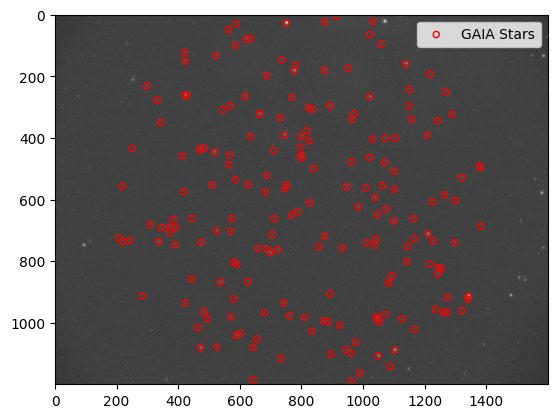

Coordenadas centrales: <SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (297.88824097, 8.89849159)>


In [2]:
# Definir el parámetro de escala o tamaño de la placa
scale = 0.822*u.arcsec # ascsec/px pixel scale se obtiene de la astrometria

# Open the FITS file con astrometria
file_path = "111_Altair_v2.fits"
print(f"Procesando archivo: {file_path}")

# Cargar los datos de la imagen FITS
hdul = fits.open(file_path)
image_data = hdul[0].data
header = hdul[0].header
wcs = WCS(header)

# Obtener las coordenadas del centro de la imagen
ny, nx = image_data.shape
center_x = nx / 2
center_y = ny / 2
center_coord = wcs.pixel_to_world(center_x, center_y)

# Definir el tamaño del rectángulo de búsqueda
pixel_width = nx * scale
pixel_height = ny * scale
width = u.Quantity(pixel_width, u.deg)
height = u.Quantity(pixel_height, u.deg)

# Realizar la consulta al catálogo GAIA
Gaia.ROW_LIMIT = 10000
j = Gaia.query_object_async(coordinate=center_coord, width=width, height=height)

# Convertir a pandas para trabajar con los datos de manera más cómoda
results_GAIA = j.to_pandas()
print("....")
print(f"Se encontraron {len (results_GAIA)} objetos en total")
print("....")
print( "Aplicando filtro de Magnitudes mas brillantes que 15")
print("....")

# Aplicar un filtro para la cantidad de objetos obtenidos
filtered_stars = results_GAIA[results_GAIA["phot_g_mean_mag"]<15]
print("....")


x_bool = []
y_bool = []

# Obtener las coordenadas de RA y Dec
ra = filtered_stars["ra"]
dec = filtered_stars["dec"]

# Convertir las coordenadas de GAIA a píxeles en la imagen
gaia_coords = SkyCoord(ra=ra.values, dec=dec.values, unit=(u.deg, u.deg))
x1, y1 = wcs.world_to_pixel(gaia_coords)

for xi in x1:
    if xi>0 and xi<image_data.shape[1]:
        x_bool.append(True)
    else:
        x_bool.append(False)

filtered_stars = filtered_stars[x_bool]

# Obtener las coordenadas de RA y Dec
ra = filtered_stars["ra"]
dec = filtered_stars["dec"]

# Convertir las coordenadas de GAIA a píxeles en la imagen
gaia_coords = SkyCoord(ra=ra.values, dec=dec.values, unit=(u.deg, u.deg))
x2, y2 = wcs.world_to_pixel(gaia_coords)

for yi in y2:
    if yi>0 and yi<image_data.shape[0]:
        y_bool.append(True)
    else:
        y_bool.append(False)
        
filtered_stars = filtered_stars[y_bool]
ra = filtered_stars["ra"]
dec = filtered_stars["dec"]
gaia_coords = SkyCoord(ra=ra.values, dec=dec.values, unit=(u.deg, u.deg))
x, y = wcs.world_to_pixel(gaia_coords)

print(f"Se encontraron {len (filtered_stars)} objetos")
print("....")
# Mostrar la imagen FITS con los puntos encontrados

plt.imshow(image_data, cmap="gray", norm=LogNorm(vmin=200, vmax=np.max(image_data)))  # Usar PowerNorm para el escalado logarítmico
plt.scatter(x, y, s=20, edgecolor="red", facecolor="none", label="GAIA Stars")  # Ajustar el tamaño y color de los puntos
plt.legend()
plt.show()
print(f"Coordenadas centrales: {center_coord}")

In [3]:
psf_model = IntegratedGaussianPRF(flux=1, sigma=2.7 / 2.35)

fit_shape = (21, 21)

finder = DAOStarFinder(6.0, 2.0)

psfphot = PSFPhotometry(psf_model, fit_shape, finder=finder,
                        aperture_radius=4)

In [4]:
from astropy.table import QTable

init_params = QTable()

init_params['x'] = x

init_params['y'] = y

original_image = image_data.copy()

In [5]:
phot = psfphot(image_data, init_params=init_params)
resid = psfphot.make_residual_image(image_data, (9, 9))

In [6]:
def minmax(data):
    scaler = MinMaxScaler()
    scaler.fit(data)
    return scaler.transform(data)


stars_tbl = Table()

stars_tbl['x'] = phot["x_fit"]

stars_tbl['y'] = phot["y_fit"]  

mean_val, median_val, std_val = sigma_clipped_stats(image_data, sigma=2.0)  
image_data = image_data.astype(np.float64) - median_val  
field_data = NDData(image_data)

psf_image = psfphot.make_model_image(image_data.shape, (9,9))
ns_psf_image = np.sqrt(minmax(psf_image))
psf_field_data = NDData(psf_image)

stars = extract_stars(field_data, stars_tbl, size=9)  

In [7]:

def fxn(): #we enclose this procedure in a function for putting it in an ignoring deprecation class
    x_fwhm = []
    y_fwhm = []
    radii = []
    for i in range(len(stars)):
        # Generate fake data
        rng = np.random.default_rng(0)
        
        z = np.array(stars[i])
        y, x = np.mgrid[:z.shape[0], :z.shape[1]]
        
        
        p_init = models.Gaussian2D()
        fit_p = fitting.LevMarLSQFitter()
        with warnings.catch_warnings():
            # Ignore model linearity warning from the fitter
            warnings.filterwarnings('ignore', message='Model is linear in parameters',
                                    category=AstropyUserWarning)
            p = fit_p(p_init, x, y, z)
    
        if p.x_fwhm < 1 or p.y_fwhm < 1:
            x_fwhm.append(0) 
            y_fwhm.append(0) 
            radii.append(0)
        else:
            x_fwhm.append(p.x_fwhm) 
            y_fwhm.append(p.y_fwhm) 
            if p.x_fwhm < p.y_fwhm:
                radii.append(p.x_fwhm)
            else:
                radii.append(p.y_fwhm)
    
    x_fwhm = np.array(x_fwhm, dtype=np.float32)
    y_fwhm = np.array(y_fwhm, dtype=np.float32)
    radii = np.array(radii, dtype=np.float32)
    x_star = stars.center_flat[:,0]
    y_star = stars.center_flat[:,1]

    return x_star, y_star, x_fwhm, y_fwhm, radii

with warnings.catch_warnings(action="ignore"):
    x_star, y_star, x_fwhm, y_fwhm, radii = fxn()

In [8]:
final_catalog = {
    "GAIA_ID": filtered_stars["SOURCE_ID"],
    "RA": filtered_stars["ra"],
    "DEC": filtered_stars["dec"],
    "x_star": x_star,
    "y_star": y_star,
    "x_fwhm": x_fwhm,
    "y_fwhm": y_fwhm,
    "radii": radii
} 

final_catalog = pd.DataFrame(final_catalog).reset_index(drop=True)

In [9]:
final_catalog.head()

,GAIA_ID,RA,DEC,x_star,y_star,x_fwhm,y_fwhm,radii
0,4298625444222272000,297.889923,8.891965,827.420296,610.820694,5.082814,7.833457,5.082814
1,4298625444222268672,297.897652,8.900370,787.186058,639.847527,0.000000,0.000000,0.000000
2,4298625478582006528,297.900675,8.904128,768.776372,650.311550,6.983356,3.019425,3.019425
3,4298625650380726272,297.881560,8.911412,747.755187,564.435314,6.422816,5.795435,5.795435
4,4298625719100205824,297.878787,8.910602,752.484258,552.751399,7.559214,6.958179,6.958179


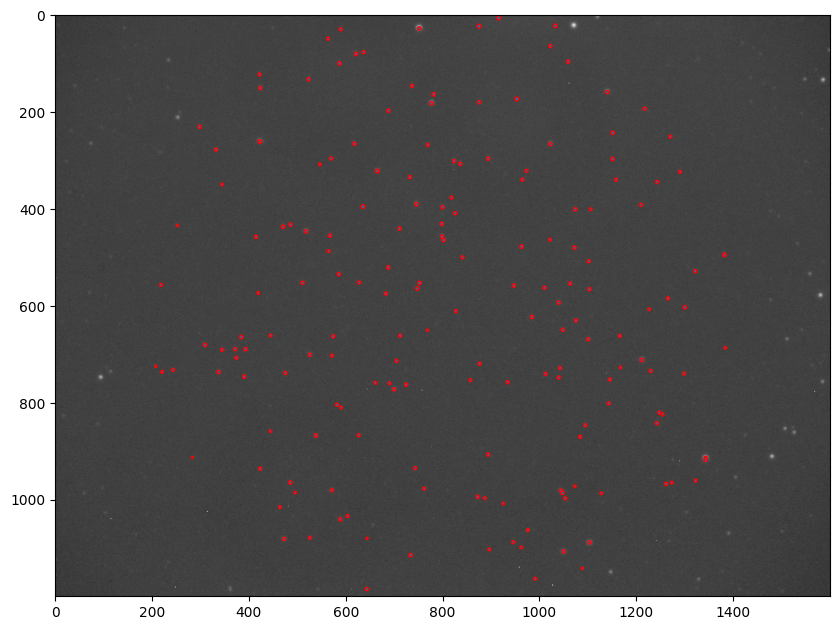

In [10]:
fig, ax = plt.subplots(figsize = (10,10))
ax.imshow(original_image, cmap="gray", norm=LogNorm(vmin=200, vmax=np.max(original_image)))
ax.scatter(final_catalog["x_star"], final_catalog["y_star"], s=final_catalog["radii"], facecolor=None, edgecolor="red")

plt.show()